# Tracking Demonstration

This notebook applies vehicles [**tracking**](#Apply-Tracking) for **a single 8-minute-video** using [pytorch_objectdetecttrack](https://github.com/cfotache/pytorch_objectdetecttrack) with a few minor modifications (e.g. accelerated renewal of tracking after a frame with no detection), shows various [**properties of the trackings**](#Explanatory-Descriptive-Analysis), studies some [**anomalies**](#Invalid-Trackings-Study) in the trackings (most of them relate to the detection & tracking algorithms rather than behavior of the vehicles), and studies the [**driving speed**](#Driving-Speed-Analysis) of the cars along the video.

- [**Tracking**](#Apply-Tracking)
- [**Explanatory Descriptive Analysis**](#Explanatory-Descriptive-Analysis)
- [**Anomalies Study**](#Invalid-Trackings-Study)
- [**Driving Speed Analysis**](#Driving-Speed-Analysis)
- [**Summary**](#Summary)

## Configuration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter, OrderedDict
import cv2
from PIL import Image
from IPython.display import clear_output

In [3]:
import track_tools as tt
clear_output()

In [4]:
mpl.rcParams.update({'font.size': 14})
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

In [5]:
MODE = 'save' # 'load' / 'save' / None
OUT_PATH = Path('tracking_demo_data')
OUT_FILE = OUT_PATH/'20190612_175832.slow.pkl' # '20190612_175832.slow.pkl' / 'tmp.pkl'
MAX_FRAMES = np.Inf # np.Inf
AREA = (0, 650, -350, -50)
DISPLAY = False
FPS = 30/8

DATA = Path(r'D:\Media\Videos\Ayalon')
# videopath = str(DATA/'20190622_124116.mp4') # bad detection
# videopath = str(DATA/'20190703_163050_slipping_protest.2.mp4') # fast
videopath = str(DATA/'20190612_175832.mp4') # slow

## Apply Tracking

In [6]:
if MODE == 'load':
    
    with open(OUT_FILE,'rb') as f:
        dct = pkl.load(f)
    X = dct['X']
    Y = dct['Y']
    S = dct['S']
    C = dct['C']
    W = dct['W'] if 'W' in dct else AREA[1]-AREA[0]
    H = dct['H'] if 'H' in dct else AREA[3]-AREA[2]
    
else:

    %pylab inline
    X,Y,S,C,other_objs,W,H = tt.analyze_video(videopath, area=AREA, MAX_FRAMES=MAX_FRAMES, DISPLAY=DISPLAY)

Max permitted sequentially-missing frames in tracking: 6
Elapsed time:	51.8 [min]


In [7]:
df, slope = tt.summarize_video(X,Y,S,C,W,H,FPS)
df.head()

d:\code\python\Ayalon\objectdetecttrack\track_tools.py:452: RuntimeWarning: invalid value encountered in longlong_scalars
  for car in X.columns]


Data frame shape:
(1265, 27)


,class,n_shots,consistent_class,consistent_xy_nas,continuous_track,avg_size,max_size,valid_size,neg_x_motion,neg_y_motion,...,dt,dx,dy,x_path_rel,y_path_rel,long_path,v,abs_v,road_perpendicularity,perpendicular_range
12,truck,8,True,True,False,102.162959,108.226614,True,0.000000,0.000000,...,2.133333,108.5,27.0,0.166923,0.090000,False,52.410464,52.604975,36.818106,8.434137
11,car,40,True,True,True,58.064291,61.911227,True,0.000000,0.019417,...,10.400000,337.0,99.0,0.518462,0.330000,True,33.773140,34.461132,27.825183,8.965070
10,car,3,True,True,True,65.790297,67.601775,True,0.000000,0.000000,...,0.533333,25.0,10.0,0.038462,0.033333,False,50.485920,50.831730,69.331938,2.648182
9,car,12,True,True,False,55.809030,57.801384,True,0.226415,0.052632,...,4.800000,20.5,9.0,0.031538,0.030000,False,4.664294,6.207561,-7.937183,4.594104
8,car,26,True,True,False,60.642076,66.648331,True,0.000000,0.005236,...,8.000000,334.5,94.5,0.514615,0.315000,True,43.449054,43.564228,52.190381,8.968409


In [8]:
if MODE == 'save':
    with open(OUT_FILE,'wb') as f:
        pkl.dump({'X':X, 'Y':Y, 'S':S, 'C':C, 'W':W, 'H':H, 'others':other_objs, 'df':df}, f)

In [9]:
gc.collect()

63

## Explanatory Descriptive Analysis

In [10]:
mpl.rcParams.update({'font.size': 13})

#### Show all trackings

Wall time: 4.01 s


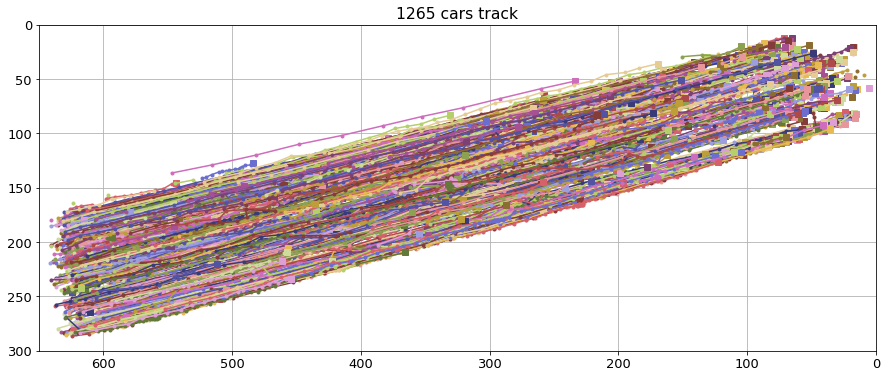

In [11]:
%%time

plt.figure(figsize=(15,6))
plt.title(f'{X.shape[1]:d} cars track')
tt.set_track_figure(W,H)

for car in X.columns:
    tt.plot_track(X,Y,car)

#### Show distributions of data columns

In [12]:
variables_groups_to_compare = (
    ('consistent_class','consistent_xy_nas','valid_size','valid_x_dir','valid_y_dir'),
    ('continuous_track','long_path'),
    ('min_x','max_x'),
    ('min_y','max_y'),
    ('avg_size','max_size'),
    ('v','abs_v'),
)

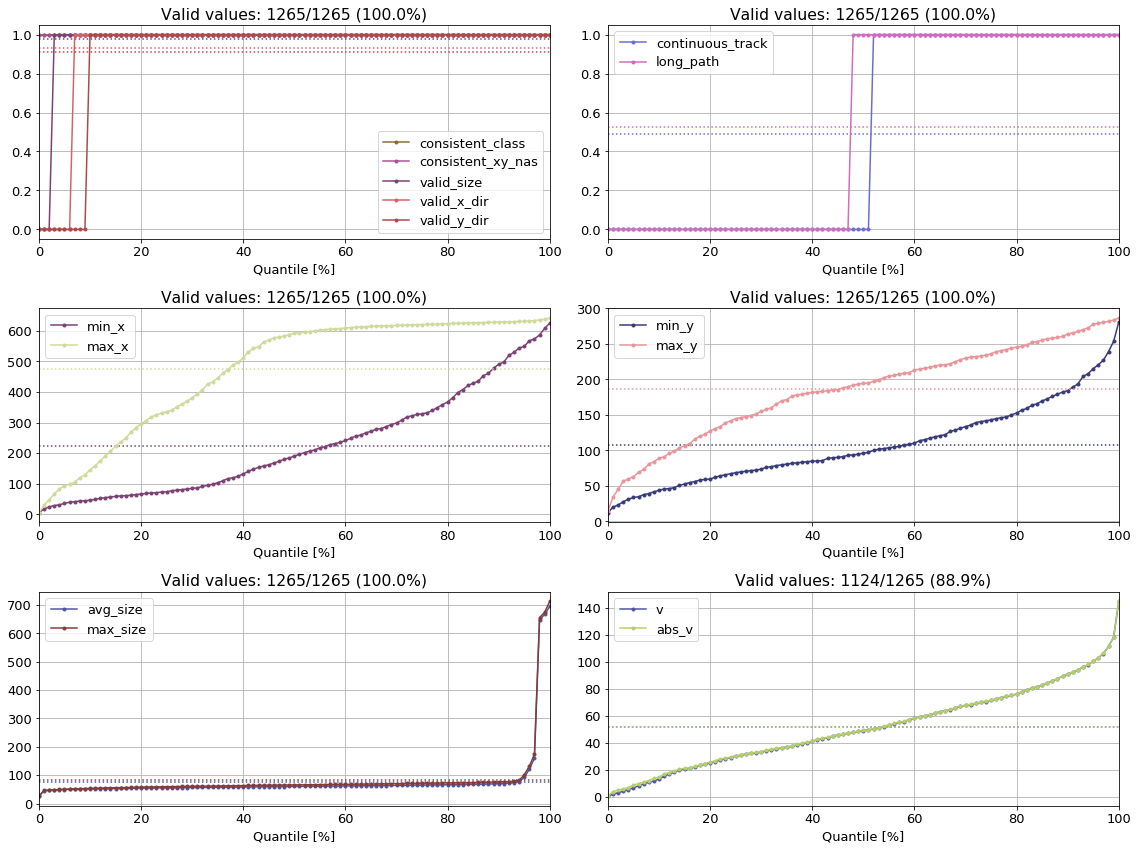

In [13]:
n_rows = int(np.ceil(5/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

for i, cols in enumerate(variables_groups_to_compare):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.qplots(df.loc[:,cols])

plt.tight_layout()

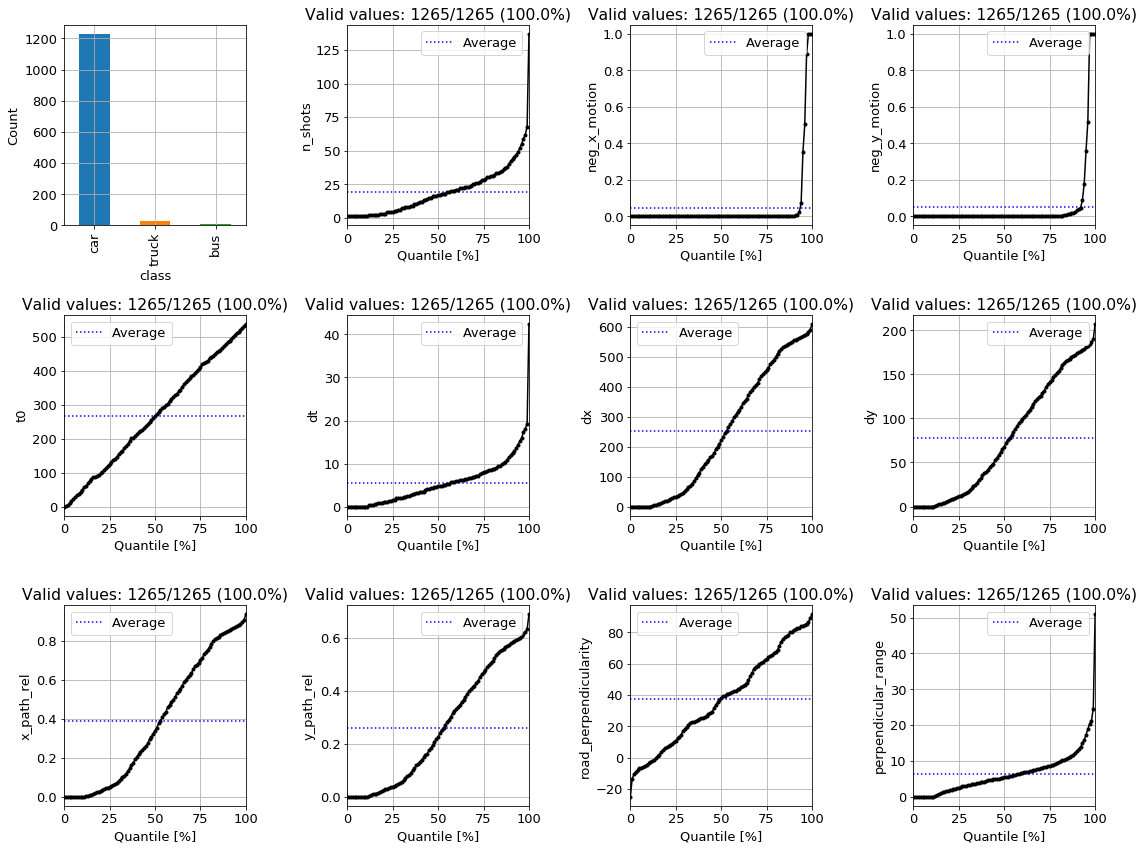

In [14]:
cols = [col for col in df.columns if not col in [c for grp in variables_groups_to_compare for c in grp]]
n_rows = int(np.ceil(len(cols)/4))
_, axs = plt.subplots(n_rows, 4, figsize=(16,n_rows*4))

for i,c in enumerate(cols):
    ax = plt.subplot(n_rows, 4, i+1)
    if type(df[c][0]) is str:
        df[c].value_counts().plot('bar')
        ax.set_xlabel(c)
        ax.set_ylabel('Count')
        ax.grid()
    else:
        tt.qplot(df[c], ax=ax, ylab=c, logscale=False)

plt.tight_layout()

#### Show relations between a few pairs of columns

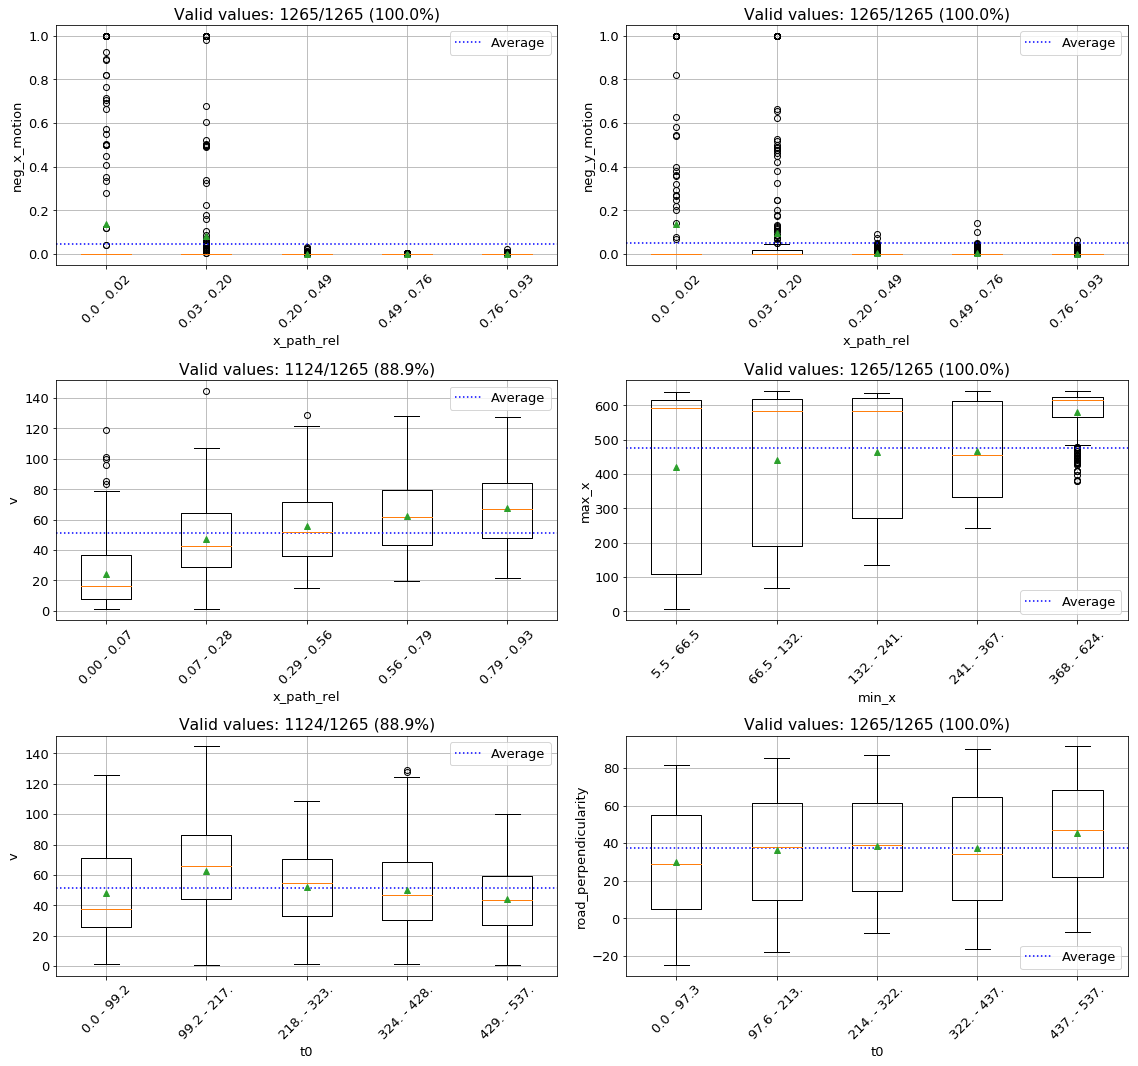

In [15]:
pairs = (
    ('x_path_rel','neg_x_motion'),
    ('x_path_rel','neg_y_motion'),
    ('x_path_rel','v'),
    ('min_x','max_x'),
    ('t0','v'),
    ('t0','road_perpendicularity'),
)

n_rows = int(np.ceil(len(pairs)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*5))

for i,(c1,c2) in enumerate(pairs):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.boxplot_per_bucket(df[c1], df[c2], ax=ax, xlab=c1, ylab=c2, logscale=False)

plt.tight_layout()

## Invalid Trackings Study

Valid fields:  consistent_class, consistent_xy_nas

valid_x_dir overlaps (all=84):
{'valid_y_dir': 69, 'valid_size': 23, 'long_path': 84, 'continuous_track': 75}

valid_y_dir overlaps (all=116):
{'valid_x_dir': 69, 'valid_size': 22, 'long_path': 101, 'continuous_track': 103}

valid_size overlaps (all=31):
{'valid_x_dir': 23, 'valid_y_dir': 22, 'long_path': 31, 'continuous_track': 24}

long_path overlaps (all=600):
{'valid_x_dir': 84, 'valid_y_dir': 101, 'valid_size': 31, 'continuous_track': 241}

continuous_track overlaps (all=645):
{'valid_x_dir': 75, 'valid_y_dir': 103, 'valid_size': 24, 'long_path': 241}


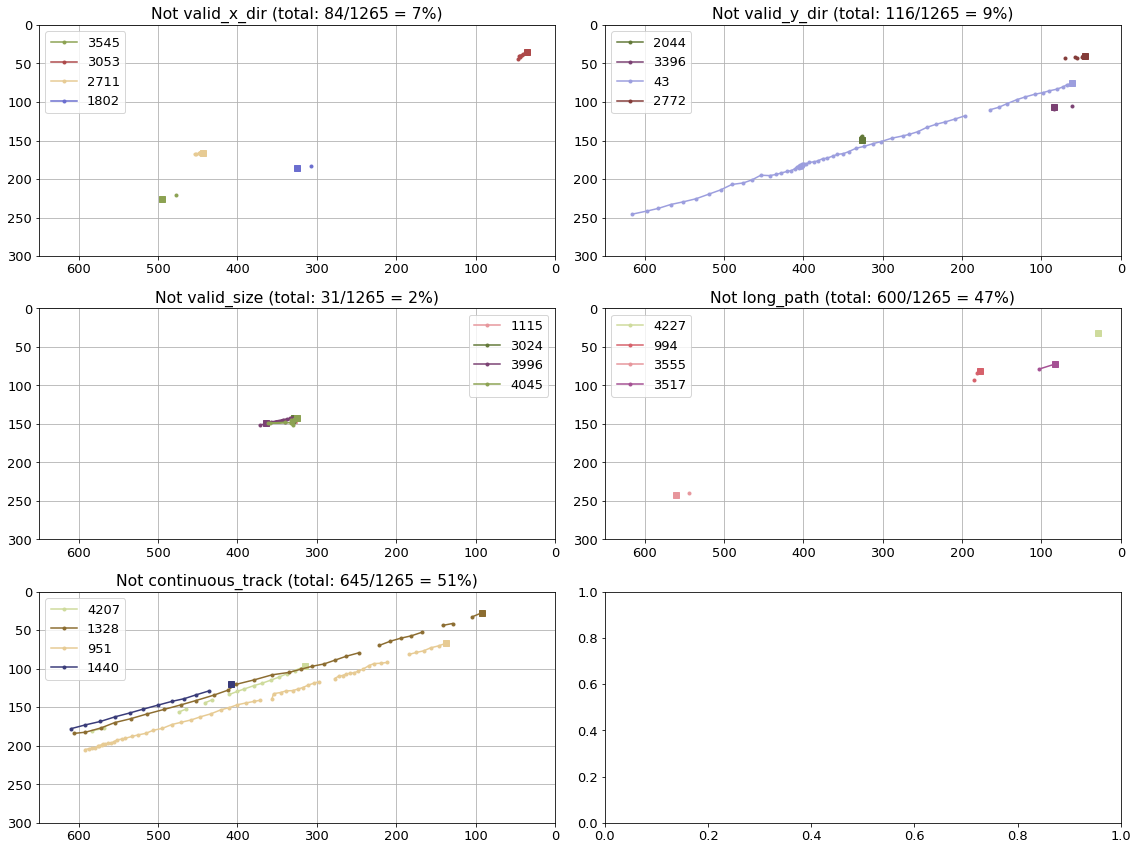

In [16]:
validations = ('consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir','valid_size','long_path','continuous_track')
n_samples = 4

all_valid = [val for val in validations if df[val].all()]
print('Valid fields: ', ', '.join(all_valid))

validations = [val for val in validations if val not in all_valid]
n_rows = int(np.ceil(len(validations)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

for i,val in enumerate(validations):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.set_track_figure(W,H,ax)
    
    cars = df.index[np.logical_not(df[val])]
    n_bad = len(cars)
    if n_samples < len(cars):
        cars = np.random.choice(cars, n_samples, replace=False)
    
    for car in cars:
        tt.plot_track(X,Y,car,ax)
    ax.set_title(f'Not {val:s} (total: {n_bad:d}/{df.shape[0]:d} = {100*n_bad/df.shape[0]:.0f}%)')
    ax.legend()
    
    print(f'\n{val:s} overlaps (all={np.sum(np.logical_not(df[val])):d}):')
    print({val2: np.sum(np.logical_not(df.loc[np.logical_not(df[val]),val2])) for val2 in validations if val2!=val})

plt.tight_layout()

In [17]:
assert(False), "Change IDs below and go on"

AssertionError: Change IDs below and go on

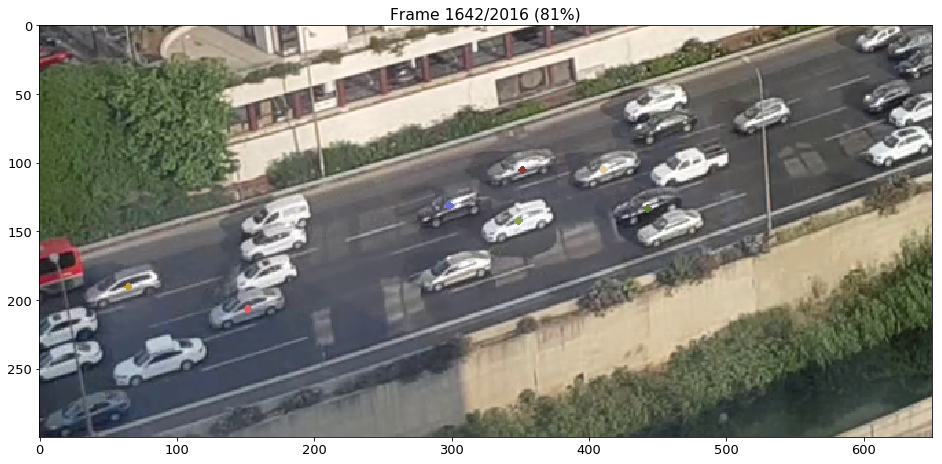

In [20]:
tt.record_video(videopath, X, Y, '3517', self_track=1, display=True, extra_frames=30)

"Large" cars:

In [ ]:
tt.record_frame(videopath, X, Y, '1100', frm=1, self_track=3,
                display=True, boxes=True, to_save=OUT_PATH/'large_car', TITLE='"Large car"')

Negative motion along y-axis:

In [ ]:
tt.record_video(videopath, X, Y, '1568', self_track=8, display=False, to_save=OUT_PATH/'neg_y')
clear_output()

In [ ]:
tt.record_frame(videopath, X, Y, '1568', frm=25, self_track=8, display=True, to_save=OUT_PATH/'neg_y',
                TITLE='Invalid motion direction in Y-axis - simply detection confusion')

Motion perpendicular to the road:

In [ ]:
plt.figure(figsize=(12,4))

for i in range(-10,91,20):
    plt.plot(np.linspace(0, W, 100), slope*np.linspace(0, W, 100) + i, 'k--', alpha=0.5)

tt.set_track_figure(W,H)
car = np.random.choice(df.index[df.perpendicular_range>30])
tt.plot_track(X,Y,car)
plt.legend()

In [ ]:
tt.record_frame(videopath, X, Y, '5120', frm=15, self_track=4, display=False, to_save=OUT_PATH/'perp1a')
tt.record_frame(videopath, X, Y, '5120', frm=19, self_track=4, display=True, to_save=OUT_PATH/'perp1b',
               TITLE='Motion perpendicular to road - simply detection confusion')

In [ ]:
tt.record_video(videopath, X, Y, '5120', self_track=4, display=False, to_save=OUT_PATH/'perp2')
clear_output()

In [ ]:
tt.record_video(videopath, X, Y, '82', self_track=1, extra_frames=30, display=True, to_save=OUT_PATH/'short')

## Driving Speed Analysis

In [ ]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)

print(f'Valid tracks:\t{ids.sum()}/{len(ids)} ({100*ids.mean():.0f}%)')

_, axs = plt.subplots(2,2, figsize=(16,10))
tt.qplot(df.v[ids], ylab=f'Speed (avg = {df.v[ids].mean():.0f})', ax=axs[0,0])
tt.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=8, xlab='Time [s]', ylab='Speed [pixels / s]', ax=axs[1,0])
tt.boxplot_per_bucket(df.road_perpendicularity[ids], df.v[ids],
                      xlab='Line [arbitrary units]', ylab='Speed [pixels / s]', ax=axs[1,1])
plt.tight_layout()

In [ ]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)
ids = np.logical_and(ids, df.road_perpendicularity<29)

plt.figure(figsize=(18,6))
tt.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=530//10, xlab='Time [s]', ylab='Average speed (right only) [pixels / s]')

In [ ]:
times = list(np.arange(10, df.t0.max()-20, 1/FPS))
decay = 10 # 1/e factor every "decay" seconds
ws = [np.exp(-np.abs(df[ids].t0-t)/decay) for t in times]
rolling_speed = [np.sum(w*df[ids].v)/np.sum(w) for w in ws]

_, axs = plt.subplots(1,1,figsize=(16,4))
ax = axs
ax.plot(times, rolling_speed)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Average speed (right only) [pixels / s]')
ax.set_ylim((0,None))
ax.grid()

In [ ]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)

fastest = df[ids].v.argmax()
slowest = df[ids].v.argmin()

tt.record_video(videopath, X, Y, fastest, display=False, to_save=OUT_PATH/'fastest')
tt.record_video(videopath, X, Y, slowest, display=False, to_save=OUT_PATH/'slowest')
clear_output()

In [ ]:
car = fastest
fast_speeds = np.power(np.power(X[car][X[car].notnull()].diff()[1:],2) + np.power(Y[car][Y[car].notnull()].diff()[1:],2), 0.5) /\
              np.diff(np.array(X.index[X[car].notnull()]))

car = slowest
slow_speeds = np.power(np.power(X[car][X[car].notnull()].diff()[1:],2) + np.power(Y[car][Y[car].notnull()].diff()[1:],2), 0.5) /\
              np.diff(np.array(X.index[X[car].notnull()]))

plt.figure(figsize=(12,3))
plt.hist(list(fast_speeds), label='Fastest car')
plt.hist(list(slow_speeds), label='Slowest car')
plt.xlabel('Speed [pixels / s]')
plt.ylabel('Number of frames')
plt.title('Histograms of speeds of a single car')
plt.grid()
plt.legend()
clear_output()

## Summary

#### Detection:

- It looks like the **detection rate** of the vehicles does not reach 50%. It is unknown whether there is relevant filter bias in the detected vehicles (e.g. it might be that crowded vehicles are not detected, leading to filtering of slower drivings from the data.

#### Anomalous trackings:

| Phenomenon | Estimated frequency | Estimated reasons | Solution |
| --- | --- | --- | --- |
| **Vehicles are not detected** | 40-80% of the vehicles in a frame are not detected in a convenient video (bright with no reflections) | Apparently mainly due to being small and crowded | [**TODO**] Try to decrease the boxes of YOLO? Try to apply some dedicated additional learning somehow? |
| **Very short paths** (< 30% of the observed road) | 50% of tracks | mis-detection for more than a single frame (often due to presence of a street light pole) causes loss of tracking; in addition, few short paths correspond to fake detections | Since the motion is quite predictable and objects cannot disappear behind anything in the middle of a frame, the number of permitted frames without detection was increased from 1 to 3, reducing total tracks from 1410 to 1211 and short paths from 56% to 45%. Further increase of no-detection frames did not help. |
| **Incontinuous track -> missing frames in paths** | 33% of tracks | Few frames are missing due to mis-detections; others are missing because [SORT](https://github.com/abewley/sort) requires several detections in a row before it renews the tracking | Editing SORT code to renew tracking immediately minimized the loss of information due to frames with missing detection. |
| **Very large car size** | 3% of tracks | Fake detection: a whole section of road is classified as "car" | Filtering out vehicles larger than 6 times the median removed the fake detections of this kind. |
| **Motion against road direction** | 4% of tracks | Either fake detections (see "very large car size") or short path with nearly-standing motion | Filtering out large cars and short paths solved most of the problem. |
| **Large motion in perpendicular to road** | 2% of tracks | Tracking-confusions (different vehicles are associated with the same object-ID) - and NOT actual line-transitions of cars | ignore / change Kalman noise model (Q) to consider speed direction / filter out (note: filtering perpendicular motion out means giving up on line-transition detection) |


#### Speed analysis:

- Speed varies between **lines**. In particular, the rightest line is very slow.
- Speed varies a lot over **time**, without any clear periodicity.

**TODO**
- improve tracking (see readme): see what's the noise of ratio(box) (should be in angles rather than ratio); see what's the noise of the location in perpendicular direction.
   - Predicted location x=Fx has nothing to do with noises.
   - Estimated error P=FPFt+Q slightly affects x when updating location according to observation: if P is smaller, then observation (i.e. new detection) will be less dominant than predicted location.
   - To decrease P in the direction perpendicular to the motion - I would like Q to interact with the speed (encoded in x). In practice, the most reasonable wrap-up is to **change Q[0,0]=a & Q[1,1]=b manually every iteration according to the speed direction vx,vy**: ... .
- update conclusions.
- run over all videos (not in notebook).
- improve detection.